In [1]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import shap
# shap.initjs()

In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from IPython.display import display

In [3]:
pd.set_option('display.max_rows', 100, 'display.max_columns', None)

In [4]:
train_file = 'data/train_raw.csv'
# test_file = 'data/train_raw.csv'

In [5]:
import random
random.seed(42)
# read data
print('Reading CSV...')
t_df = pd.read_csv(train_file, index_col=0, dtype='float')
print('Done')
t_df['id'] = t_df['id'].astype(int)
t_df['id'] = t_df['id'].astype(int)
# split train-validation
sick = set(t_df[t_df['SepsisLabel'] == 1.0]['id'].unique())
healthy = set(t_df['id'].unique()) - sick
t_sick = set(random.sample(tuple(sick), int(0.75*len(sick))))
v_sick = sick - t_sick
t_healthy = set(random.sample(tuple(healthy), int(0.75*len(healthy))))
v_healthy = healthy - t_healthy

train = t_df[t_df.id.isin(list(t_sick) + list(t_healthy))].sort_values(['id', 'SepsisLabel'])
valid = t_df[t_df.id.isin(list(v_sick) + list(v_healthy))].sort_values(['id', 'SepsisLabel'])

Reading CSV...
Done


In [39]:
train

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,id,Unit3,Gender_0.0,Gender_1.0
0.0,61.000000,99.000000,36.440000,124.000000,65.000000,43.000000,17.500000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,75.91,0.0,1.0,-98.60,1.0,0.0,0,0.0,1.0,0.0
1.0,61.000000,99.000000,36.440000,124.000000,65.000000,43.000000,17.500000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,75.91,0.0,1.0,-98.60,2.0,0.0,0,0.0,1.0,0.0
2.0,63.250000,98.250000,36.440000,124.750000,64.250000,41.500000,24.625000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,75.91,0.0,1.0,-98.60,3.0,0.0,0,0.0,1.0,0.0
3.0,58.230769,99.461538,36.440000,123.538462,64.769231,41.153846,13.807692,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,75.91,0.0,1.0,-98.60,4.0,0.0,0,0.0,1.0,0.0
4.0,63.475000,99.150000,36.440000,121.150000,66.275000,42.400000,20.012500,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,75.91,0.0,1.0,-98.60,5.0,0.0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776714.0,92.990280,97.882567,36.447763,128.615857,89.877763,60.150472,15.603230,47.057456,0.078947,0.078947,0.236842,0.105263,0.078947,0.0,0.0,0.078947,0.0,0.052632,0.078947,0.078947,0.0,0.078947,0.0,0.105263,0.026316,0.105263,0.0,0.0,0.078947,0.078947,0.052632,0.078947,0.0,0.078947,38.75,0.0,1.0,-0.05,38.0,0.0,19998,0.0,0.0,1.0
776715.0,73.451416,97.098386,37.161072,123.626040,73.992964,52.020070,15.955769,47.057456,0.076923,0.076923,0.230769,0.102564,0.076923,0.0,0.0,0.076923,0.0,0.051282,0.076923,0.076923,0.0,0.076923,0.0,0.102564,0.025641,0.102564,0.0,0.0,0.076923,0.076923,0.051282,0.076923,0.0,0.076923,38.75,0.0,1.0,-0.05,39.0,0.0,19998,0.0,0.0,1.0
776716.0,73.451416,97.098386,37.161072,123.626040,73.992964,52.020070,15.955769,47.057456,0.075000,0.075000,0.225000,0.100000,0.075000,0.0,0.0,0.075000,0.0,0.050000,0.075000,0.075000,0.0,0.075000,0.0,0.100000,0.025000,0.100000,0.0,0.0,0.075000,0.075000,0.050000,0.075000,0.0,0.075000,38.75,0.0,1.0,-0.05,40.0,0.0,19998,0.0,0.0,1.0
776717.0,73.050176,97.010936,37.161072,124.847282,76.665763,54.668775,15.995084,47.057456,0.073171,0.073171,0.219512,0.097561,0.073171,0.0,0.0,0.073171,0.0,0.048780,0.073171,0.073171,0.0,0.073171,0.0,0.097561,0.024390,0.097561,0.0,0.0,0.073171,0.073171,0.048780,0.073171,0.0,0.073171,38.75,0.0,1.0,-0.05,41.0,0.0,19998,0.0,0.0,1.0


# Logistic Regression

## Feature Engineering

### Add features

In [6]:
# for each vineyard that has records from 2020 or 2021, find the last 4 years' mean total weight per size
# def last_four_years_mean(vineyard_id, year):
#     first_list = [2016, 2017, 2018, 2019]
#     second_list = [2017, 2018, 2019, 2020]
#     if year == 2020:
#         weight_df = vine_df.loc[(vine_df['vineyard_id'] == vineyard_id) & (vine_df['measure_year']).isin(first_list)]['plot_total_weight/plot_size']
#     else:
#         weight_df = vine_df.loc[(vine_df['vineyard_id'] == vineyard_id) & (vine_df['measure_year']).isin(second_list)]['plot_total_weight/plot_size']
#     return weight_df.mean(axis=0)

### Aggregating-Normalizing Features
We normalize vital signs by the avg of the feature to get a relative feature value
For LR:
We aggregate x last hours of features for each patient in train.
We aggregate every x hours of features for the patient and return a final prediction in test.

In [32]:
HOURS = 7

In [33]:
max_cols = ['ICULOS', 'SepsisLabel']
mean_cols = [col for col in train if col not in ['id'] + max_cols]
X_t = pd.concat([train.groupby('id')[mean_cols].apply(lambda x: x.tail(HOURS).mean()), train.groupby('id')[max_cols].apply(lambda x: x.tail(HOURS).max())], axis=1)

### Scaling Features

In [34]:
scaling_columns = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'Age', 'HospAdmTime', 'ICULOS']  # rest are already scaled
scaler = MinMaxScaler()
X_t[scaling_columns] = scaler.fit_transform(X_t[scaling_columns])

In [35]:
y_t = X_t['SepsisLabel']
X_t = X_t.drop(['SepsisLabel'], axis=1)

In [36]:
X_t

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Unit1,Unit2,HospAdmTime,Unit3,Gender_0.0,Gender_1.0,ICULOS
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.161853,0.948382,0.435328,0.470862,0.183927,0.158683,0.159127,0.277778,0.000000,0.050509,0.000000,0.000000,0.000000,0.000000,0.000000,0.050509,0.000000,0.050509,0.050509,0.050509,0.0,0.050509,0.000000,0.050509,0.050509,0.050509,0.000000,0.0,0.050509,0.050509,0.000000,0.050509,0.0,0.050509,0.716588,0.0,1.0,0.968900,0.0,1.0,0.0,0.065672
1,0.439165,1.000000,0.636655,0.564638,0.398206,0.335046,0.217865,0.277778,0.117489,0.131434,0.242430,0.117489,0.117489,0.000000,0.000000,0.087623,0.000000,0.087623,0.087623,0.087623,0.0,0.205112,0.117489,0.087623,0.087623,0.087623,0.000000,0.0,0.131434,0.131434,0.087623,0.087623,0.0,0.087623,0.597529,0.0,0.0,0.995343,1.0,0.0,1.0,0.074627
2,0.313071,0.927166,0.497741,0.604998,0.462890,0.466228,0.202119,0.277778,0.000000,0.028665,0.085996,0.000000,0.000000,0.000000,0.028665,0.028665,0.028665,0.000000,0.028665,0.028665,0.0,0.028665,0.000000,0.028665,0.000000,0.028665,0.028665,0.0,0.028665,0.028665,0.028665,0.028665,0.0,0.028665,0.445647,1.0,0.0,0.995346,0.0,0.0,1.0,0.110448
3,0.233610,0.961862,0.562038,0.522588,0.423038,0.461268,0.191409,0.277778,0.000000,0.031388,0.000000,0.000000,0.000000,0.000000,0.000000,0.031388,0.000000,0.031388,0.031388,0.031388,0.0,0.075920,0.000000,0.031388,0.031388,0.031388,0.000000,0.0,0.031388,0.031388,0.031388,0.031388,0.0,0.031388,0.406118,0.0,0.0,0.995343,1.0,0.0,1.0,0.140299
4,0.468750,0.939373,0.536424,0.403750,0.373162,0.362324,0.201356,0.277778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048058,0.000000,0.048058,0.000000,0.048058,0.0,0.204395,0.000000,0.096116,0.000000,0.096116,0.000000,0.0,0.048058,0.048058,0.000000,0.048058,0.0,0.048058,0.682353,1.0,0.0,0.937774,0.0,0.0,1.0,0.068657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19993,0.271271,0.988661,0.544126,0.385980,0.279186,0.466228,0.146347,0.411750,0.060699,0.042630,0.267571,0.103329,0.060699,0.039384,0.000000,0.042630,0.000000,0.042630,0.042630,0.042630,0.0,0.124645,0.048133,0.051379,0.051379,0.090763,0.000000,0.0,0.197339,0.103329,0.039384,0.042630,0.0,0.042630,0.378471,0.0,0.0,0.995341,1.0,0.0,1.0,0.146269
19995,0.530675,0.963611,0.616783,0.402349,0.385898,0.406816,0.227637,0.411750,0.077383,0.000000,0.270841,0.154766,0.077383,0.077383,0.000000,0.038692,0.000000,0.000000,0.000000,0.038692,0.0,0.154766,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.181294,0.181294,0.000000,0.000000,0.0,0.000000,0.526000,0.0,1.0,0.994244,0.0,0.0,1.0,0.083582
19996,0.212803,0.983380,0.433922,0.556201,0.569145,0.596366,0.170700,0.411750,0.125314,0.050126,0.336024,0.125314,0.125314,0.000000,0.000000,0.050126,0.000000,0.050126,0.050126,0.050126,0.0,0.050126,0.025063,0.050126,0.050126,0.050126,0.000000,0.0,0.075188,0.025063,0.000000,0.025063,0.0,0.025063,0.598000,0.0,0.0,0.995341,1.0,0.0,1.0,0.125373


### Selecting Features

In [37]:
sfs = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=0.5, scoring='f1', n_jobs=-1)
sfs = sfs.fit(X_t, y_t)
chosen_numeric = X_t.columns[sfs.support_]
print('Chosen numeric columns:', chosen_numeric)
X_t = pd.DataFrame(sfs.transform(X_t), columns=chosen_numeric, index=X_t.index)

Chosen numeric columns: Index(['HR', 'O2Sat', 'Temp', 'SBP', 'DBP', 'Resp', 'EtCO2', 'FiO2', 'BUN',
       'Creatinine', 'Bilirubin_direct', 'Glucose', 'Magnesium', 'Phosphate',
       'Hgb', 'WBC', 'Fibrinogen', 'Unit1', 'Unit2', 'Unit3', 'ICULOS'],
      dtype='object')


In [38]:
clf = LogisticRegressionCV(cv=5, random_state=0, scoring='f1', max_iter=10000).fit(X_t, y_t)

clf.score(X_t, y_t)

0.10097431355181576

In [47]:

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)

for i in X_t.rolling(indexer):
    print(i)
    break

          HR     O2Sat      Temp       SBP       DBP      Resp     EtCO2  \
id                                                                         
0   0.161853  0.948382  0.435328  0.470862  0.158683  0.159127  0.277778   
1   0.439165  1.000000  0.636655  0.564638  0.335046  0.217865  0.277778   
2   0.313071  0.927166  0.497741  0.604998  0.466228  0.202119  0.277778   
3   0.233610  0.961862  0.562038  0.522588  0.461268  0.191409  0.277778   
4   0.468750  0.939373  0.536424  0.403750  0.362324  0.201356  0.277778   

        FiO2       BUN  Creatinine  Bilirubin_direct   Glucose  Magnesium  \
id                                                                          
0   0.000000  0.050509    0.050509               0.0  0.050509   0.050509   
1   0.242430  0.087623    0.087623               0.0  0.205112   0.087623   
2   0.085996  0.028665    0.028665               0.0  0.028665   0.028665   
3   0.000000  0.031388    0.031388               0.0  0.075920   0.031388   
4   0

In [32]:
model = Pipeline(
    steps=[
        ('estimator', ElasticNetCV())
    ],
    verbose=True
)

estimators = [
    {
        "estimator": [
            ElasticNetCV(),
            LassoCV(),
            RidgeCV(),
            MLPRegressor()
        ]
    },
    {
        "estimator": [SVR()],
        "estimator__kernel": ["linear", "poly", "rbf", "sigmoid"]
    },
    {
        "estimator": [KNeighborsRegressor()],
        "estimator__n_neighbors": [3, 5, 7],
        "estimator__weights": ['uniform', 'distance']
    }
]

grid = GridSearchCV(model,
                    param_grid=estimators,
                    scoring='neg_mean_absolute_percentage_error',
                    refit=True,
                    cv=5,
                    n_jobs=-1,
                    verbose=10)

grid.fit(X_features, y)
pd.DataFrame(grid.cv_results_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[Pipeline] ......... (step 1 of 1) Processing estimator, total=   0.0s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__kernel,param_estimator__n_neighbors,param_estimator__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.206001,0.015150,0.005399,0.001960,ElasticNetCV(),NaN,NaN,NaN,{'estimator': ElasticNetCV()},-0.578538,-0.315665,-0.274876,-0.271324,-0.398687,-0.367818,0.114913,3
1,0.171600,0.013590,0.004002,0.003520,LassoCV(),NaN,NaN,NaN,{'estimator': LassoCV()},-0.545916,-0.322415,-0.268467,-0.262123,-0.402492,-0.360283,0.105585,2
2,0.011402,0.013821,0.004998,0.003033,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",NaN,NaN,NaN,"{'estimator': RidgeCV(alphas=array([ 0.1, 1. ...",-0.664350,-0.295874,-0.255139,-0.288527,-0.386913,-0.378160,0.149613,4
3,0.337801,0.038614,0.004398,0.001743,MLPRegressor(),NaN,NaN,NaN,{'estimator': MLPRegressor()},-0.525335,-0.447063,-0.308089,-0.379082,-0.417340,-0.415382,0.072009,12
4,0.033400,0.003496,0.002598,0.000491,SVR(kernel='linear'),linear,NaN,NaN,"{'estimator': SVR(kernel='linear'), 'estimator...",-0.499866,-0.316407,-0.239394,-0.255430,-0.412406,-0.344700,0.098508,1
5,0.005198,0.000400,0.002402,0.000490,SVR(kernel='linear'),poly,NaN,NaN,"{'estimator': SVR(kernel='linear'), 'estimator...",-0.580673,-0.451622,-0.310811,-0.445034,-0.433055,-0.444239,0.085554,14
6,0.005000,0.000001,0.003201,0.000400,SVR(kernel='linear'),rbf,NaN,NaN,"{'estimator': SVR(kernel='linear'), 'estimator...",-0.582752,-0.426199,-0.266225,-0.276553,-0.379663,-0.386278,0.115492,8
7,0.005599,0.000801,0.003202,0.000401,SVR(kernel='linear'),sigmoid,NaN,NaN,"{'estimator': SVR(kernel='linear'), 'estimator...",-0.515376,-0.439301,-0.322205,-0.397498,-0.544528,-0.443782,0.080273,13
8,0.003201,0.000402,0.003401,0.000798,KNeighborsRegressor(),NaN,3,uniform,"{'estimator': KNeighborsRegressor(), 'estimato...",-0.624236,-0.434992,-0.296314,-0.249175,-0.344764,-0.389896,0.132322,9
9,0.003000,0.000003,0.003801,0.000399,KNeighborsRegressor(),NaN,3,distance,"{'estimator': KNeighborsRegressor(), 'estimato...",-0.618345,-0.431008,-0.293183,-0.244858,-0.341003,-0.385679,0.131583,7


In [33]:
from sklearn.model_selection import train_test_split
import time

X_train,X_test,y_train,y_test  = train_test_split(X_features, y, test_size=0.2, random_state=0)

# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
X_train_summary = shap.kmeans(X_train, 10)

def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_test) - y_test)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars

In [34]:
model = SVR(kernel='linear')
model.fit(X_train, y_train)

print_accuracy(model.predict)

Root mean squared test error = 0.8512233162752305


In [35]:
svm_explainer = shap.KernelExplainer(model.predict, X_train_summary)
shap_values = svm_explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(svm_explainer.expected_value, shap_values, X_test.iloc[0,:])

X does not have valid feature names, but SVR was fitted with feature names
X does not have valid feature names, but SVR was fitted with feature names
X does not have valid feature names, but SVR was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


  0%|          | 0/40 [00:00<?, ?it/s]

X does not have valid feature names, but SVR was fitted with feature names
X does not have valid feature names, but SVR was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVR was fitted with feature names
X does not have valid feature names, but SVR was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprec

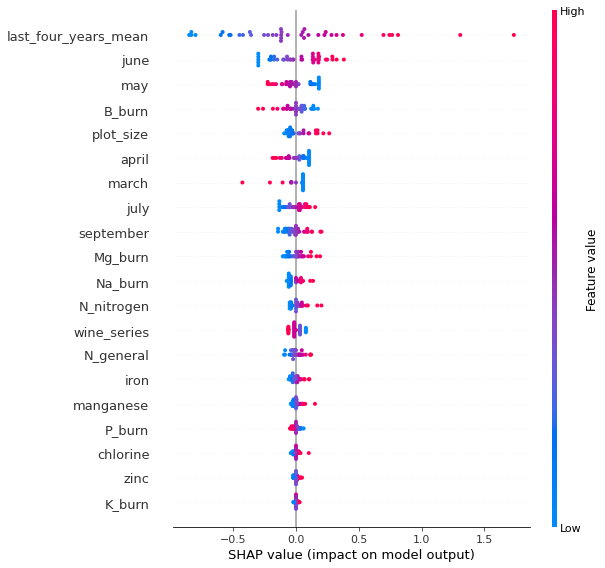

In [36]:
svm_shap_values = svm_explainer.shap_values(X_test)
shap.summary_plot(svm_shap_values, X_test)

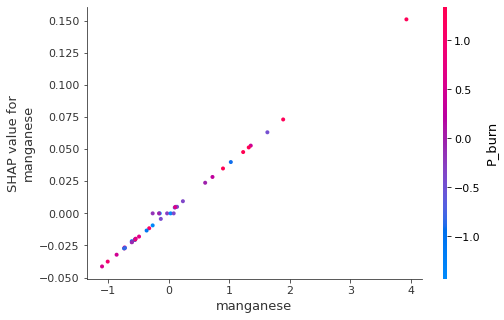

In [37]:
shap.dependence_plot("manganese", svm_shap_values, X_test)

In [38]:
shap.force_plot(svm_explainer.expected_value, svm_shap_values, X_test)